<a href="https://colab.research.google.com/github/mihikap01/Codeflash-NeuroKit/blob/master/Gut_Microbiome_to_ASD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, precision_score
from xgboost import XGBClassifier

# some hyper parameters
SEED = 1970
test_train_split_SEED = 1970
# FOLDS = 10
show_fold_stats = True
VERBOSE = 0
FOLDS = 5

The dataset is from the research paper by Zhou Dan et al. published on April 21st of 2020 - [Altered gut microbial profile is associated with abnormal metabolism activity of Autism Spectrum Disorder](https://www.tandfonline.com/doi/full/10.1080/19490976.2020.1747329)

From the Abstract:<br>
> Autism Spectrum Disorder (ASD) is a severe neurodevelopmental disorder. To enhance the understanding of the gut microbiota structure in ASD children at different ages as well as the relationship between gut microbiota and fecal metabolites, we first used the 16S rRNA sequencing to evaluate the gut microbial population in a cohort of 143 children aged 2–13 years old. We found that the α-diversity of ASD group showed no significant change with age, while the TD group showed increased α-diversity with age, which indicates that the compositional development of the gut microbiota in ASD varies at different ages in ways that are not consistent with TD group. Recent studies have shown that chronic constipation is one of the most commonly obvious gastrointestinal (GI) symptoms along with ASD core symptoms. To further investigate the potential interaction effects between ASD and GI symptoms, the 30 C-ASD and their aged-matched TD were picked out to perform metagenomics analysis. We observed that C-ASD group displayed decreased diversity, depletion of species of Sutterella, Prevotella, and Bacteroides as well as dysregulation of associated metabolism activities, which may involve in the pathogenesis of C-ASD. Consistent with metagenomic analysis, liquid chromatography-mass spectrometry (LC/MS) revealed some of the differential metabolites between C-ASD and TD group were involved in the metabolic network of neurotransmitters including serotonin, dopamine, histidine, and GABA. Furthermore, we found these differences in metabolites were associated with altered abundance of specific bacteria. The study suggested possible future modalities for ASD intervention through targeting the specific bacteria associated with neurotransmitter metabolism.

In [ ]:
!gdown 1PhvbvywalgrkthVi8T6W4D-wNG1D6KtX
!gdown 1YfgZuMVO4pS0x0KPV8QjX8MR8dF3GMbJ

Downloading...
From: https://drive.google.com/uc?id=1PhvbvywalgrkthVi8T6W4D-wNG1D6KtX
To: /content/ASD meta abundance.csv
100% 973k/973k [00:00<00:00, 24.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YfgZuMVO4pS0x0KPV8QjX8MR8dF3GMbJ
To: /content/GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv
100% 955k/955k [00:00<00:00, 16.4MB/s]


In [ ]:
pd_abundance = pd.read_csv('GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv')
pd_meta_abundance = pd.read_csv('ASD meta abundance.csv')

In [ ]:
taxa = pd_abundance[['OTU', 'taxonomy']].set_index('OTU')
pd_abundance_T = pd_abundance.drop('taxonomy', axis=1).set_index('OTU').transpose()

target = pd_abundance_T.index.to_list()
binary_target = np.array([1 if t.startswith('A') else 0 for t in target ])

total_species = pd_abundance_T.sum(axis = 1)
abs_abundance = 31757
pd_rel_abundance = pd_abundance_T / abs_abundance

First will try 16s rRNA using both RF and XGBoost

In [ ]:
# Lets put aside a small test set, so we can check performance of different classifiers against it
disease_train, disease_test, disease_y_train, disease_y_test = train_test_split(pd_rel_abundance, binary_target, test_size = 0.05,  random_state = test_train_split_SEED , shuffle = True)

In [ ]:
skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for fold, (idxT,idxV) in enumerate(skf.split(disease_train, disease_y_train)):

    X_train = disease_train.iloc[idxT]
    X_val = disease_train.iloc[idxV]
    y_train = disease_y_train[idxT]
    y_val = disease_y_train[idxV]

    #clf = RandomForestClassifier(n_estimators = 500, random_state = SEED, verbose = 0)
    clf = LogisticRegression()
    clf.fit(X_train, y_train )

    RF_pred_class = clf.predict(X_val)
    RF_preds = clf.predict_proba(X_val)

    RF_AUC_test_score = roc_auc_score(y_val, RF_preds[:,1])
    RF_f1_test = f1_score(y_val, RF_pred_class)
    RF_recall_test = recall_score(y_val, RF_pred_class)
    RF_precision_test = precision_score(y_val, RF_pred_class)

    if show_fold_stats:
        print('-' * 80)
        print('Fold : %s'%(fold+1))
        print('ROC AUC score for RandomForest model, validation set: %.4f'%RF_AUC_test_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(RF_f1_test, RF_recall_test, RF_precision_test))
        print(confusion_matrix(y_val, RF_pred_class))

    XGB_model = XGBClassifier(n_estimators=5000, max_depth=None,
                        learning_rate=0.005,
                        objective='binary:logistic',
                        metric='auc',
                        verbosity  = VERBOSE,
                        # tree_method = 'gpu_hist',
                        use_label_encoder=False,
                        early_stopping_rounds=100,
                        n_jobs=-1, random_state  = SEED )

    XGB_model.fit(X_train, y_train,
                    eval_set = [(X_val, y_val)],
                    #eval_metric=['logloss'],
                    #early_stopping_rounds = 100,
                    verbose = VERBOSE )

    XGB_preds = XGB_model.predict_proba(X_val)
    XGB_class = XGB_model.predict(X_val)

    XGB_score = roc_auc_score(y_val, XGB_preds[:,1])
    XGB_f1 = f1_score(y_val, XGB_class)
    XGB_recall = recall_score(y_val, XGB_class)
    XGB_precision = precision_score(y_val, XGB_class)

    if show_fold_stats:
        print('ROC AUC score for XGBoost model, validation set: %.4f'%XGB_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(XGB_f1, XGB_recall, XGB_precision))
        print(confusion_matrix(y_val, XGB_class))

    RF_preds_test = clf.predict_proba(disease_test)
    XGB_preds_test = XGB_model.predict_proba(disease_test)
    avg_preds_test = (RF_preds_test[:,1] + XGB_preds_test[:,1]) / 2

    RF_test_AUC = roc_auc_score(disease_y_test, RF_preds_test[:,1])
    print('ROC AUC score for RF for test set: %.4f'%RF_test_AUC)
    XGB_test_AUC = roc_auc_score(disease_y_test, XGB_preds_test[:,1])
    print('ROC AUC score for XGBoost model test set: %.4f'%XGB_test_AUC)
    average_AUC = roc_auc_score(disease_y_test, avg_preds_test )
    print('ROC AUC score averaged between 2 models for test set: %.4f'%average_AUC)

    avg_class = np.where(avg_preds_test < 0.7, 0, 1)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(f1_score(disease_y_test, avg_class), recall_score(disease_y_test, avg_class), precision_score(disease_y_test, avg_class)))
    print(confusion_matrix(disease_y_test, avg_class))

--------------------------------------------------------------------------------
Fold : 1
ROC AUC score for RandomForest model, validation set: 0.6786
F1 : 0.7273, Recall : 1.0000 , Precision : 0.5714
[[ 0 21]
 [ 0 28]]
ROC AUC score for XGBoost model, validation set: 0.9558
F1 : 0.9123, Recall : 0.9286 , Precision : 0.8966
[[18  3]
 [ 2 26]]
ROC AUC score for RF for test set: 0.4048
ROC AUC score for XGBoost model test set: 0.9286
ROC AUC score averaged between 2 models for test set: 0.9048
F1 : 0.8333, Recall : 0.8333 , Precision : 0.8333
[[6 1]
 [1 5]]
--------------------------------------------------------------------------------
Fold : 2
ROC AUC score for RandomForest model, validation set: 0.7464
F1 : 0.7368, Recall : 1.0000 , Precision : 0.5833
[[ 0 20]
 [ 0 28]]
ROC AUC score for XGBoost model, validation set: 0.9625
F1 : 0.9825, Recall : 1.0000 , Precision : 0.9655
[[19  1]
 [ 0 28]]
ROC AUC score for RF for test set: 0.5238
ROC AUC score for XGBoost model test set: 0.8810
RO

Lets try metagenomic data: 30 samples with ASD and 30 TD

In [ ]:
# exclude absent spcecies
pd_meta_abundance = pd_meta_abundance[pd_meta_abundance.iloc[:, 1:].sum(axis = 1) !=0]

In [ ]:
pd_meta_abundance

,Taxonomy,A3,A5,A6,A9,A31,A51,A52,A53,A54,...,B120,B127,B132,B141,B142,B143,B152,B156,B158,B164
0,g__Faecalibacterium;s__Faecalibacterium prausn...,4988,5060,2905,5745,4822,3889,4646,6337,5064,...,4471,5868,6561,4910,4492,2812,5303,4205,3430,4563
1,g__Hungatella;s__Hungatella hathewayi,5803,5612,4109,1432,2652,4175,3891,894,4903,...,2126,4429,2598,4222,4925,5753,1261,1822,2478,4868
2,g__Clostridium;s__uncultured Clostridium sp.,3793,2795,1355,5558,5383,3505,5541,4429,4121,...,4085,6041,6188,3960,4403,2841,2746,3808,3856,3211
3,g__Butyricimonas;s__Butyricimonas virosa,64,1385,725,1553,40,53,33,175,58,...,2065,21,27,55,35,8,884,13,3,218
4,g__Alistipes;s__Alistipes indistinctus,15,20,723,620,3261,43,83,37,43,...,90,22,30,1027,2641,4,1587,2223,6,1473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5452,g__Unclassified;s__Skermania phage SPI1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5453,g__Unclassified;s__Vibrio phage vB_VhaS-tm,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5454,g__Unclassified;s__uncultured Mediterranean ph...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5455,g__Unclassified;s__uncultured Mediterranean ph...,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [ ]:
pd_meta_abndc = pd_meta_abundance.drop(['Taxonomy'], axis=1).T
target = pd_meta_abndc.index.to_list()
binary_target = np.array([1 if t.startswith('A') else 0 for t in target ])

In [ ]:
# this subset of data is too small to have a separate test set, so we'd have to rely on CV only
skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
for fold, (idxT,idxV) in enumerate(skf.split(pd_meta_abndc, binary_target)):

    X_train = pd_meta_abndc.iloc[idxT]
    X_val = pd_meta_abndc.iloc[idxV]
    y_train = binary_target[idxT]
    y_val = binary_target[idxV]

    #clf = RandomForestClassifier(n_estimators = 500, random_state = SEED, verbose = 0)
    clf = LogisticRegression()
    clf.fit(X_train, y_train )

    RF_pred_class = clf.predict(X_val)
    RF_preds = clf.predict_proba(X_val)

    RF_AUC_test_score = roc_auc_score(y_val, RF_preds[:,1])
    RF_f1_test = f1_score(y_val, RF_pred_class)
    RF_recall_test = recall_score(y_val, RF_pred_class)
    RF_precision_test = precision_score(y_val, RF_pred_class)

    if show_fold_stats:
        print('-' * 80)
        print('Fold : %s'%(fold+1))
        print('ROC AUC score for RandomForest model, validation set: %.4f'%RF_AUC_test_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(RF_f1_test, RF_recall_test, RF_precision_test))
        print(confusion_matrix(y_val, RF_pred_class))

    XGB_model = XGBClassifier(n_estimators=5000, max_depth=None,
                        learning_rate=0.005,
                        objective='binary:logistic',
                        metric='auc',
                        verbosity  = VERBOSE,
                        # tree_method = 'gpu_hist',
                        use_label_encoder=False,
                        early_stopping_rounds=100,
                        n_jobs=-1, random_state  = SEED )

    XGB_model.fit(X_train, y_train,
                    eval_set = [(X_val, y_val)],
                    #eval_metric=['logloss'],
                    #early_stopping_rounds = 100,
                    verbose = VERBOSE )

    XGB_preds = XGB_model.predict_proba(X_val)
    XGB_class = XGB_model.predict(X_val)

    XGB_score = roc_auc_score(y_val, XGB_preds[:,1])
    XGB_f1 = f1_score(y_val, XGB_class)
    XGB_recall = recall_score(y_val, XGB_class)
    XGB_precision = precision_score(y_val, XGB_class)

    if show_fold_stats:
        print('ROC AUC score for XGBoost model, validation set: %.4f'%XGB_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(XGB_f1, XGB_recall, XGB_precision))
        print(confusion_matrix(y_val, XGB_class))

--------------------------------------------------------------------------------
Fold : 1
ROC AUC score for RandomForest model, validation set: 0.8056
F1 : 0.7273, Recall : 0.6667 , Precision : 0.8000
[[5 1]
 [2 4]]
ROC AUC score for XGBoost model, validation set: 1.0000
F1 : 1.0000, Recall : 1.0000 , Precision : 1.0000
[[6 0]
 [0 6]]
--------------------------------------------------------------------------------
Fold : 2
ROC AUC score for RandomForest model, validation set: 0.8611
F1 : 0.7273, Recall : 0.6667 , Precision : 0.8000
[[5 1]
 [2 4]]
ROC AUC score for XGBoost model, validation set: 0.7778
F1 : 0.6667, Recall : 0.6667 , Precision : 0.6667
[[4 2]
 [2 4]]
--------------------------------------------------------------------------------
Fold : 3
ROC AUC score for RandomForest model, validation set: 0.8333
F1 : 0.7692, Recall : 0.8333 , Precision : 0.7143
[[4 2]
 [1 5]]
ROC AUC score for XGBoost model, validation set: 0.9444
F1 : 0.9091, Recall : 0.8333 , Precision : 1.0000
[[6 

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(pd_meta_abndc.to_numpy())

In [ ]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
corrs = [pearsonr(df_scaled[:, i], binary_target) for i in range(5457)]

In [ ]:
import matplotlib.pyplot as plt

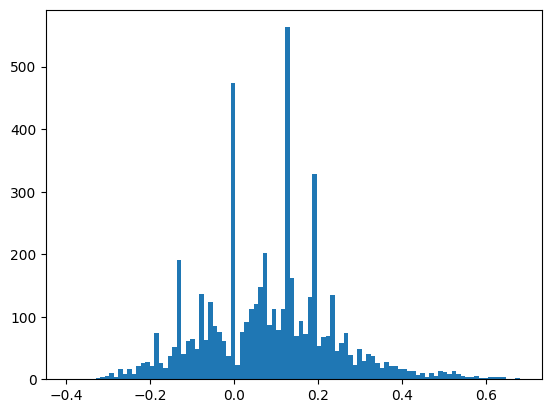

In [ ]:
plt.hist([x[0] for x in corrs], bins=100);

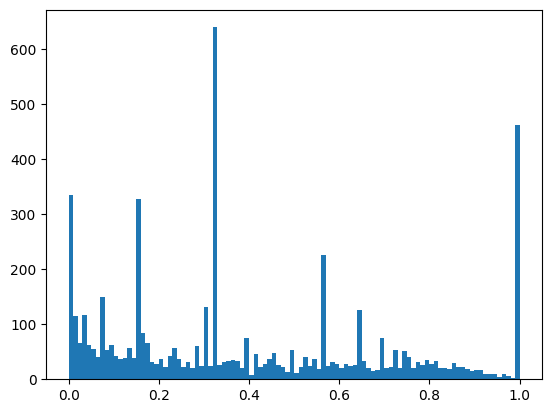

In [ ]:
plt.hist([x[1] for x in corrs], bins=100);

In [ ]:
pvals = [x[1] for x in corrs]

In [ ]:
### HOMEWORK
threshold = 0.000001

In [ ]:
good_vars = np.where(np.array(pvals) < threshold)[0]

In [ ]:
len(good_vars)

19

In [ ]:
# Assuming pd_meta_abndc and binary_target are already defined
X = df_scaled[:, good_vars]
y = binary_target

In [ ]:
X.shape

(60, 19)

In [ ]:
taxonomy = np.array(pd_meta_abundance['Taxonomy'].tolist())

In [ ]:
taxonomy[good_vars]

array(['g__Parabacteroides;s__Parabacteroides distasonis',
       'g__Bacteroides;s__Bacteroides stercoris CAG:120',
       'g__Bacteroides;s__Bacteroides salanitronis',
       'g__Bacteroides;s__Bacteroides sp. CAG:875',
       'g__Prevotella;s__Prevotella ruminicola',
       'g__Bacteroides;s__Bacteroides barnesiae',
       'g__Bacteroides;s__Bacteroides sp. CAG:598',
       'g__Bacteroides;s__Bacteroides sp. CAG:714',
       'g__Prevotella;s__Prevotella maculosa',
       'g__Prevotella;s__Prevotella sp. CAG:1320',
       'g__Bacteroides;s__Bacteroides sp. CAG:633',
       'g__Prevotella;s__Prevotella amnii',
       'g__Bacteroides;s__Bacteroides sp. Marseille-P2824',
       'g__Prevotella;s__Prevotella sp. P5-125',
       'g__Porphyromonas;s__Porphyromonas macacae',
       'g__Prevotella;s__Prevotella nanceiensis',
       'g__Prevotella;s__Prevotella oris',
       'g__Unclassified;s__Bacteroidales bacterium Barb7',
       'g__Prevotella;s__Prevotella sp. oral taxon 317'], dtype='<U8

In [ ]:
data_19 = pd.DataFrame(X,columns = taxonomy[good_vars])

In [ ]:
data_19["ASD"] = binary_target

In [ ]:
data_train, data_test = train_test_split(data_19,test_size = 0.2, random_state=42, stratify=binary_target)

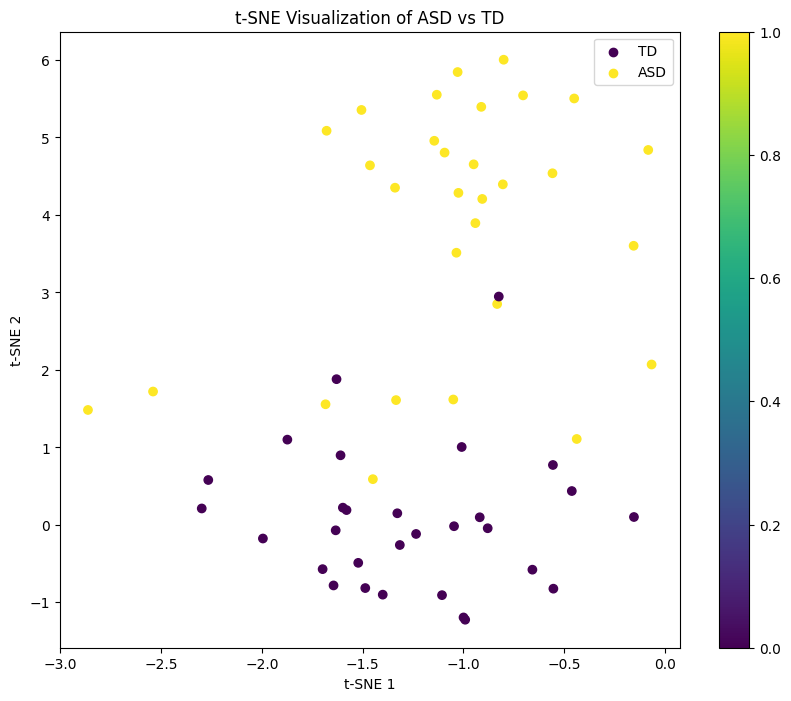

In [ ]:
# TSNE code

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter)

# Add labels and title
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of ASD vs TD')

# Add a legend
labels = ['TD', 'ASD']
handles = [plt.scatter([], [], c=color, label=label) for color, label in zip(['#440154', '#fde725'], labels)]
plt.legend(handles=handles)

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tsne,y,test_size=0.2,random_state=42)

In [ ]:
lr = LogisticRegression()

In [ ]:
lr = lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.75

In [ ]:
# define bounds of the domain
min1, max1 = X_tsne[:, 0].min()-1, X_tsne[:, 0].max()+1
min2, max2 = X_tsne[:, 1].min()-1, X_tsne[:, 1].max()+1

In [ ]:
min1, max1

(-3.8632490634918213, 0.9334681630134583)

In [ ]:
min2, max2

(-2.224097490310669, 7.003523349761963)

In [ ]:
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

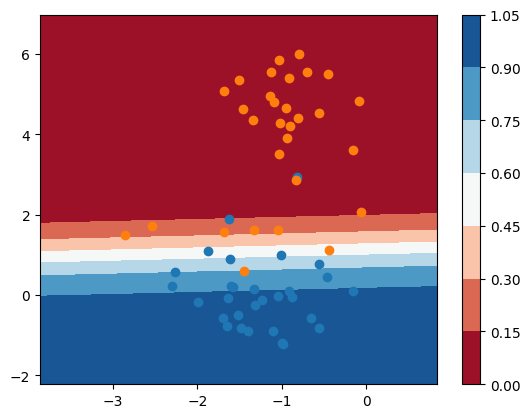

In [ ]:
# make predictions for the grid
yhat = lr.predict_proba(grid)

# keep just the probabilities for class 0
yhat = yhat[:, 0]

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')

# add a legend, called a color bar
plt.colorbar(c)

# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X_tsne[row_ix, 0], X_tsne[row_ix, 1])

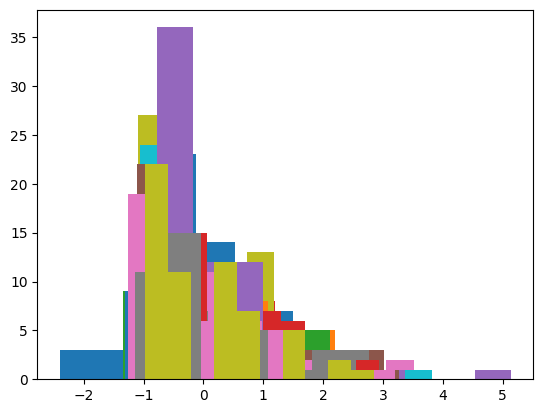

In [ ]:
for bacterium in good_vars:
  plt.hist(df_scaled[:, bacterium]);

In [ ]:
taxonomy = np.array(pd_meta_abundance['Taxonomy'].tolist())

In [ ]:
len(taxonomy)

5457

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
lr = LogisticRegression()
lr = lr.fit(X_train, y_train)

In [ ]:
np.unique(taxonomy[np.argmax(np.abs(lr.coef_*X), axis=1)])

array(['g__Alistipes;s__Alistipes indistinctus',
       'g__Clostridium;s__Clostridium sp. GD3',
       'g__Faecalibacterium;s__Faecalibacterium prausnitzii',
       'g__Hungatella;s__Hungatella hathewayi',
       'g__Lachnoclostridium;s__[Clostridium] asparagiforme',
       'g__Ruminococcus;s__Ruminococcus callidus',
       'g__Unclassified;s__Burkholderiales bacterium YL45',
       'g__Unclassified;s__Firmicutes bacterium CAG:176',
       'g__Unclassified;s__Firmicutes bacterium CAG:95'], dtype='<U85')

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [ ]:
def coefplot(results, subject):
    '''
    Takes in results of OLS model and returns a plot of
    the coefficients with 95% confidence intervals.

    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary
    coef_df = pd.DataFrame(results.summary().tables[1].data)

    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']

    # Append errors column to dataframe
    coef_df['errors'] = np.abs(errors)

    # Drop the constant for plotting
    coef_df = coef_df.drop(['Intercept'])

    # Sort values by coef ascending
    #coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)

    # Add variables column to dataframe
    coef_df['variables'] = variables

    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("notebook")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df["variables"] = final_five
    coef_df.plot(x='variables', y='coef', kind='barh',
                 ax=ax, color='none',
                 ecolor='steelblue',capsize=0,
                 xerr='errors', legend=False)

    # Set title & labels
    plt.title('Coefficients for Bacteria in ASD prediction model with 95% Confidence Intervals')
    ax.set_ylabel('Coefficients')
    ax.set_xlabel('')

    # Coefficients
    ax.scatter(y=np.arange(coef_df.shape[0]),
               marker='o', s=80,
               x=coef_df['coef'], color='steelblue')

    # Line to define zero on the y-axis
    ax.axvline(x=0, linestyle='--', color='red', linewidth=1)

    plt.tight_layout()
    plt.savefig(subject+"_coefplot.pdf")

    return None

In [ ]:
def metrics(mod):
  return np.round(mod.aic), np.round(mod.llf), np.round(mod.rsquared, 3), np.round(np.mean(np.abs(small_dataset['ASD'] - mod.fittedvalues)), 3), np.round(mod.fvalue)

In [ ]:
small_dataset  = pd_meta_abundance.iloc[np.unique(np.argmax(np.abs(lr.coef_*X), axis=1)), :].copy()

In [ ]:
small_dataset = small_dataset.transpose()

In [ ]:
small_dataset = small_dataset.reset_index()

In [ ]:
small_dataset.columns = small_dataset.iloc[0, :]

In [ ]:
small_dataset = small_dataset.iloc[1:, :]

In [ ]:
small_dataset

,Taxonomy,g__Faecalibacterium;s__Faecalibacterium prausnitzii,g__Hungatella;s__Hungatella hathewayi,g__Alistipes;s__Alistipes indistinctus,g__Unclassified;s__Firmicutes bacterium CAG:176,g__Lachnoclostridium;s__[Clostridium] asparagiforme,g__Unclassified;s__Firmicutes bacterium CAG:95,g__Clostridium;s__Clostridium sp. GD3,g__Unclassified;s__Burkholderiales bacterium YL45,g__Ruminococcus;s__Ruminococcus callidus
1,A3,4988,5803,15,100,453,17,1466,1,16
2,A5,5060,5612,20,29,691,119,1412,25,21
3,A6,2905,4109,723,11,2278,9,937,26,7
4,A9,5745,1432,620,1320,107,1938,2138,41,1359
5,A31,4822,2652,3261,51,342,49,1256,24,180
6,A51,3889,4175,43,45,1304,46,84,23,67
7,A52,4646,3891,83,52,1400,44,74,4,67
8,A53,6337,894,37,64,1207,42,1084,10,1864
9,A54,5064,4903,43,60,2034,48,1449,19,272
10,A59,6359,2970,1114,896,2051,27,1850,51,405


In [ ]:
def autism_class(label):
  if label[0] == 'A': return 1
  return 0

In [ ]:
small_dataset = small_dataset.rename(columns={"Taxonomy":"id"})

In [ ]:
small_dataset['ASD'] = small_dataset['id'].apply(autism_class)

In [ ]:
small_dataset = data_19

In [ ]:
old_columns = small_dataset.columns

In [ ]:
import re

In [ ]:
new_columns = [re.sub("[:;\. \[\]_]", "", x) for x in old_columns]

In [ ]:
new_columns

['gParabacteroidessParabacteroidesdistasonis',
 'gBacteroidessBacteroidesstercorisCAG120',
 'gBacteroidessBacteroidessalanitronis',
 'gBacteroidessBacteroidesspCAG875',
 'gPrevotellasPrevotellaruminicola',
 'gBacteroidessBacteroidesbarnesiae',
 'gBacteroidessBacteroidesspCAG598',
 'gBacteroidessBacteroidesspCAG714',
 'gPrevotellasPrevotellamaculosa',
 'gPrevotellasPrevotellaspCAG1320',
 'gBacteroidessBacteroidesspCAG633',
 'gPrevotellasPrevotellaamnii',
 'gBacteroidessBacteroidesspMarseille-P2824',
 'gPrevotellasPrevotellaspP5-125',
 'gPorphyromonassPorphyromonasmacacae',
 'gPrevotellasPrevotellananceiensis',
 'gPrevotellasPrevotellaoris',
 'gUnclassifiedsBacteroidalesbacteriumBarb7',
 'gPrevotellasPrevotellasporaltaxon317',
 'ASD']

In [ ]:
# Homework: look through the report and remove the one with the highest p-value. Keep going until you have a couple bacteria less than 0.05

In [ ]:
new_columns = ['gParabacteroidessParabacteroidesdistasonis', #Remove
 'gBacteroidessBacteroidesstercorisCAG',
 'gBacteroidessBacteroidessalanitronis',
 'gBacteroidessBacteroidesspCAGeightsevenfive',
 'gPrevotellasPrevotellaruminicola',
 'gBacteroidessBacteroidesbarnesiae',
 'gBacteroidessBacteroidesspCAGfivenineeight',
 'gBacteroidessBacteroidesspCAGsevenonefour',
 'gPrevotellasPrevotellamaculosa',
 'gPrevotellasPrevotellaspCAG', #Remove
 'gBacteroidessBacteroidesspCAGsixthreethree',
 'gPrevotellasPrevotellaamni', #Remove
 'gBacteroidessBacteroidesspMarseilleP',
 'gPrevotellasPrevotellaspP', #Remove
 'gPorphyromonassPorphyromonasmacacae',
 'gPrevotellasPrevotellananceiensis', #Remove
 'gPrevotellasPrevotellaoris',
 'gUnclassifiedsBacteroidalesbacteriumBarb',
 'gPrevotellasPrevotellasporaltaxon',
 'ASD']



In [ ]:
len(np.unique(new_columns))

20

In [ ]:
small_dataset.columns = new_columns

In [ ]:
bacteria = list(small_dataset.columns[:-1])

In [ ]:
for b in bacteria:
  small_dataset[b] = small_dataset[b].astype(int)

In [ ]:
#standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bacteria_data = small_dataset[bacteria].copy()
standardized_bacteria = pd.DataFrame(
    scaler.fit_transform(bacteria_data),
    columns=bacteria_data.columns,
    index=bacteria_data.index
)

small_dataset[bacteria] = standardized_bacteria

In [ ]:
small_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   gParabacteroidessParabacteroidesdistasonis   60 non-null     float64
 1   gBacteroidessBacteroidesstercorisCAG         60 non-null     float64
 2   gBacteroidessBacteroidessalanitronis         60 non-null     float64
 3   gBacteroidessBacteroidesspCAGeightsevenfive  60 non-null     float64
 4   gPrevotellasPrevotellaruminicola             60 non-null     float64
 5   gBacteroidessBacteroidesbarnesiae            60 non-null     float64
 6   gBacteroidessBacteroidesspCAGfivenineeight   60 non-null     float64
 7   gBacteroidessBacteroidesspCAGsevenonefour    60 non-null     float64
 8   gPrevotellasPrevotellamaculosa               60 non-null     float64
 9   gPrevotellasPrevotellaspCAG                  60 non-null     float64
 10  gBac

In [ ]:
depvar = "ASD"
mod1 = smf.ols(formula=depvar + ' ~ ' + " + ".join(bacteria), data=small_dataset)
mod1 = mod1.fit()

In [ ]:
metrics(mod1)

(61.0, -10.0, 0.668, 0.231, 4.0)

In [ ]:

mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ASD   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     4.244
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           5.87e-05
Time:                        01:14:28   Log-Likelihood:                -10.430
No. Observations:                  60   AIC:                             60.86
Df Residuals:                      40   BIC:                             102.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.5000      0.046     10.984      0.000       0.408       0.592
gParabacteroidessParabacteroidesdistasonis      0.0161      0.065      0.249      0.805      -0.115       0.147
gBacteroidessBacteroidesstercorisCAG            0.1184      0.060      1.987      0.054      -0.002       0.239
gBacteroidessBacteroidessalanitronis           -0.0958      0.114     -0.842      0.405      -0.326       0.134
gBacteroidessBacteroidesspCAGeightsevenfive     0.0703      0.072      0.983      0.332      -0.074       0.215
gPrevotellasPrevotellaruminicola                0.1273      0.067      1.886      0.067      -0.009       0.264
gBacteroidessBacteroidesbarnesiae               0.0318      0.099      0.320      0.751      -0.169       0.233
gBacteroidessBacteroidesspCAGfivenineeight      0.0294      0.087      0.336      0.739      -0.147       0.206
gBacteroidessBacteroidesspCAGsevenonefour      -0.0471      0.080     -0.585      0.562      -0.210       0.115
gPrevotellasPrevotellamaculosa                  0.0069      0.065      0.106      0.916      -0.124       0.138
gPrevotellasPrevotellaspCAG                     0.0109      0.090      0.121      0.904      -0.171       0.193
gBacteroidessBacteroidesspCAGsixthreethree      0.1092      0.080      1.365      0.180      -0.053       0.271
gPrevotellasPrevotellaamni                     -0.0039      0.083     -0.047      0.963      -0.172       0.165
gBacteroidessBacteroidesspMarseilleP            0.0542      0.064      0.844      0.404      -0.076       0.184
gPrevotellasPrevotellaspP                       0.0215      0.082      0.262      0.794      -0.144       0.187
gPorphyromonassPorphyromonasmacacae             0.0412      0.050      0.821      0.417      -0.060       0.143
gPrevotellasPrevotellananceiensis              -0.0169      0.066     -0.255      0.800      -0.151       0.117
gPrevotellasPrevotellaoris                      0.1032      0.064      1.624      0.112      -0.025       0.232
gUnclassifiedsBacteroidalesbacteriumBarb        0.1217      0.073      1.673      0.102      -0.025       0.269
gPrevotellasPrevotellasporaltaxon              -0.0281      0.066     -0.427      0.671      -0.161       0.105
==============================================================================
Omnibus:                        2.605   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.518
Skew:                           0.449   Prob(JB):                        0.284
Kurtosis:                       2.551   Cond. No.                         9.59
==============================================================================

Notes:
[1] Standard Errors assum

In [ ]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ASD   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     4.244
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           5.87e-05
Time:                        01:14:33   Log-Likelihood:                -10.430
No. Observations:                  60   AIC:                             60.86
Df Residuals:                      40   BIC:                             102.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.5000      0.046     10.984      0.000       0.408       0.592
gParabacteroidessParabacteroidesdistasonis      0.0161      0.065      0.249      0.805      -0.115       0.147
gBacteroidessBacteroidesstercorisCAG            0.1184      0.060      1.987      0.054      -0.002       0.239
gBacteroidessBacteroidessalanitronis           -0.0958      0.114     -0.842      0.405      -0.326       0.134
gBacteroidessBacteroidesspCAGeightsevenfive     0.0703      0.072      0.983      0.332      -0.074       0.215
gPrevotellasPrevotellaruminicola                0.1273      0.067      1.886      0.067      -0.009       0.264
gBacteroidessBacteroidesbarnesiae               0.0318      0.099      0.320      0.751      -0.169       0.233
gBacteroidessBacteroidesspCAGfivenineeight      0.0294      0.087      0.336      0.739      -0.147       0.206
gBacteroidessBacteroidesspCAGsevenonefour      -0.0471      0.080     -0.585      0.562      -0.210       0.115
gPrevotellasPrevotellamaculosa                  0.0069      0.065      0.106      0.916      -0.124       0.138
gPrevotellasPrevotellaspCAG                     0.0109      0.090      0.121      0.904      -0.171       0.193
gBacteroidessBacteroidesspCAGsixthreethree      0.1092      0.080      1.365      0.180      -0.053       0.271
gPrevotellasPrevotellaamni                     -0.0039      0.083     -0.047      0.963      -0.172       0.165
gBacteroidessBacteroidesspMarseilleP            0.0542      0.064      0.844      0.404      -0.076       0.184
gPrevotellasPrevotellaspP                       0.0215      0.082      0.262      0.794      -0.144       0.187
gPorphyromonassPorphyromonasmacacae             0.0412      0.050      0.821      0.417      -0.060       0.143
gPrevotellasPrevotellananceiensis              -0.0169      0.066     -0.255      0.800      -0.151       0.117
gPrevotellasPrevotellaoris                      0.1032      0.064      1.624      0.112      -0.025       0.232
gUnclassifiedsBacteroidalesbacteriumBarb        0.1217      0.073      1.673      0.102      -0.025       0.269
gPrevotellasPrevotellasporaltaxon              -0.0281      0.066     -0.427      0.671      -0.161       0.105
==============================================================================
Omnibus:                        2.605   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.518
Skew:                           0.449   Prob(JB):                        0.284
Kurtosis:                       2.551   Cond. No.                         9.59
==============================================================================

Notes:
[1] Standard Errors assum

In [ ]:
#homework, session 20
new_columns = [
    #'gParabacteroidessParabacteroidesdistasonis',
    'gBacteroidessBacteroidesstercorisCAG',
    #'gBacteroidessBacteroidessalanitronis',
    'gBacteroidessBacteroidesspCAGeightsevenfive',
    'gPrevotellasPrevotellaruminicola',
    #'gBacteroidessBacteroidesbarnesiae',
    #'gBacteroidessBacteroidesspCAGfivenineeight',
    #'gBacteroidessBacteroidesspCAGsevenonefour',
    #'gPrevotellasPrevotellamaculosa',
    #'gPrevotellasPrevotellaspCAG',
    #'gBacteroidessBacteroidesspCAGsixthreethree',
    #'gBacteroidessBacteroidesspMarseilleP',
    #'gPrevotellasPrevotellaspP',
    #'gPorphyromonassPorphyromonasmacacae',
    #'gPrevotellasPrevotellananceiensis',
    'gPrevotellasPrevotellaoris',
    'gUnclassifiedsBacteroidalesbacteriumBarb',
    #'gPrevotellasPrevotellasporaltaxon',
    'ASD'
]



# Get the bacteria columns (excluding ASD)
bacteria = [col for col in new_columns if col != 'ASD']

# Only keep the columns we want in our dataset
small_dataset = small_dataset[new_columns]

# Convert to integers
for b in bacteria:
    small_dataset[b] = small_dataset[b].astype(int)

# Standardize only the bacteria we're keeping
scaler = StandardScaler()
bacteria_data = small_dataset[bacteria].copy()
standardized_bacteria = pd.DataFrame(
    scaler.fit_transform(bacteria_data),
    columns=bacteria_data.columns,
    index=bacteria_data.index
)
small_dataset[bacteria] = standardized_bacteria

# Fit the model with only the bacteria we're keeping
depvar = "ASD"
mod1 = smf.ols(formula=depvar + ' ~ ' + " + ".join(bacteria), data=small_dataset)
mod1 = mod1.fit()
print(mod1.summary())

KeyError: "['gBacteroidessBacteroidesstercorisCAG'] not in index"

In [ ]:
# fix names for homework
final_five = [
    'Bacteroidess Bacteroidesstercoris CAG',
    'Bacteroidess Bacteroidessp CAG 875',
    'Prevotellas Prevotellaruminicola',
    'Prevotellas Prevotellaoris',
    'Bacteroidales bacterium Barb',
]

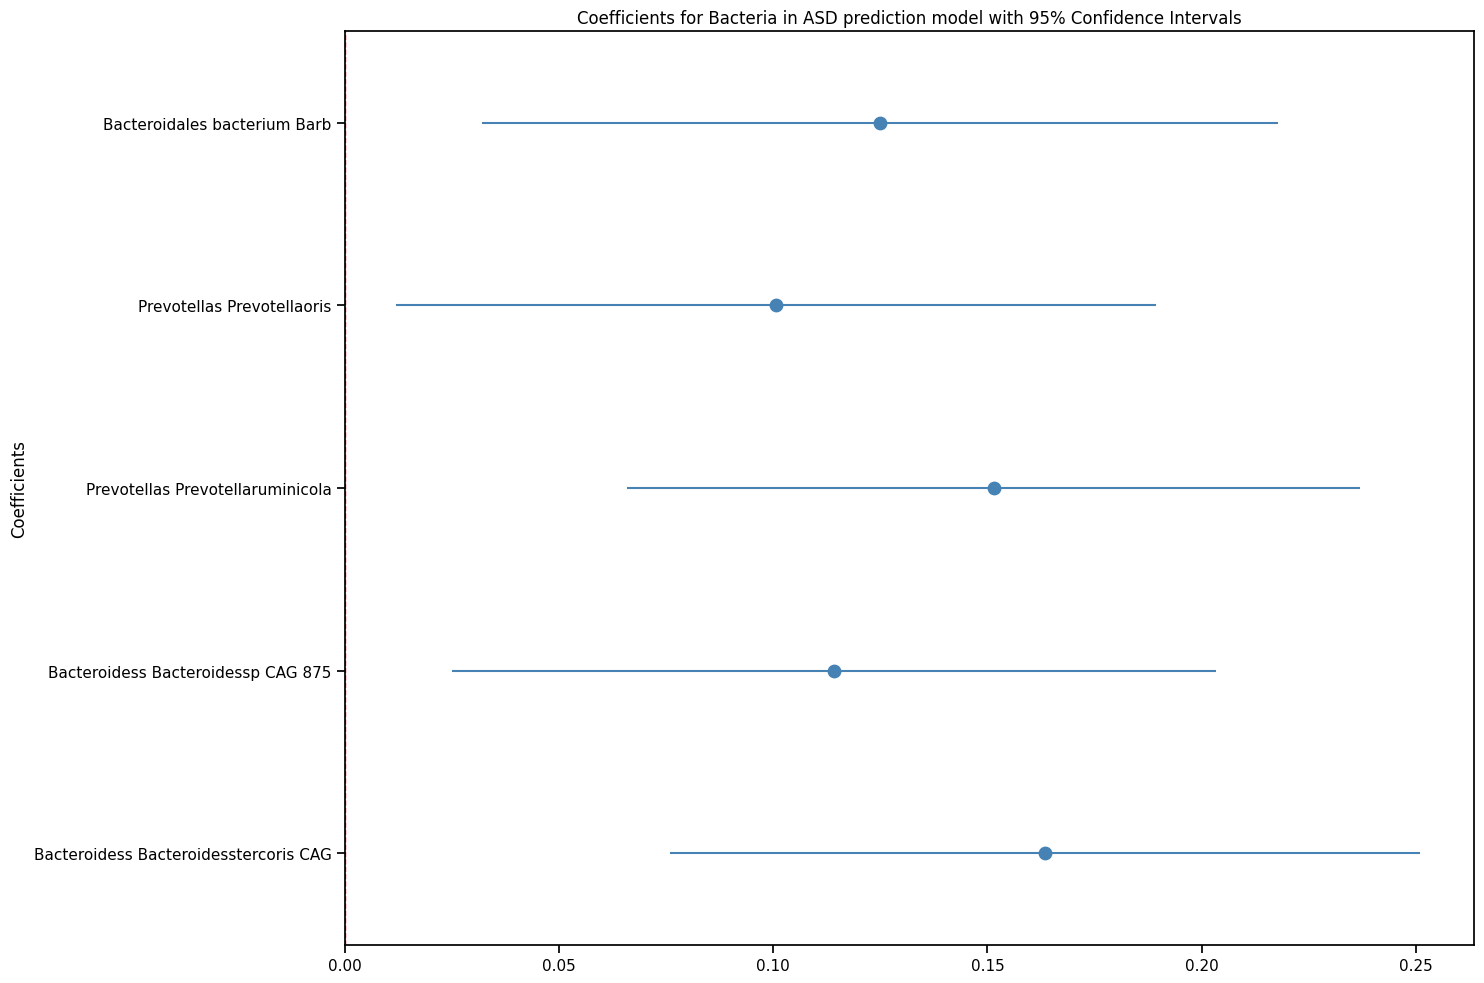

In [ ]:
coefplot(mod1, depvar)

In [ ]:
#homework, session 20
new_columns = [
    #'gParabacteroidessParabacteroidesdistasonis',
    #'gBacteroidessBacteroidesstercorisCAG',
    #'gBacteroidessBacteroidessalanitronis',
    'gBacteroidessBacteroidesspCAGeightsevenfive',
    'gPrevotellasPrevotellaruminicola',
    #'gBacteroidessBacteroidesbarnesiae',
    #'gBacteroidessBacteroidesspCAGfivenineeight',
    #'gBacteroidessBacteroidesspCAGsevenonefour',
    #'gPrevotellasPrevotellamaculosa',
    #'gPrevotellasPrevotellaspCAG',
    #'gBacteroidessBacteroidesspCAGsixthreethree',
    #'gBacteroidessBacteroidesspMarseilleP',
    #'gPrevotellasPrevotellaspP',
    #'gPorphyromonassPorphyromonasmacacae',
    #'gPrevotellasPrevotellananceiensis',
    'gPrevotellasPrevotellaoris',
    'gUnclassifiedsBacteroidalesbacteriumBarb',
    #'gPrevotellasPrevotellasporaltaxon',
    'ASD'
]

# Get the bacteria columns (excluding ASD)
bacteria = [col for col in new_columns if col != 'ASD']

# Only keep the columns we want in our dataset
small_dataset = small_dataset[new_columns]

# Convert to integers
for b in bacteria:
    small_dataset[b] = small_dataset[b].astype(int)

# Standardize only the bacteria we're keeping
scaler = StandardScaler()
bacteria_data = small_dataset[bacteria].copy()
standardized_bacteria = pd.DataFrame(
    scaler.fit_transform(bacteria_data),
    columns=bacteria_data.columns,
    index=bacteria_data.index
)
small_dataset[bacteria] = standardized_bacteria

# Fit the model with only the bacteria we're keeping
depvar = "ASD"
mod2 = smf.ols(formula=depvar + ' ~ ' + " + ".join(bacteria), data=small_dataset)
mod2 = mod2.fit()
print(mod2.summary())

<ipython-input-70-cc94b3007704>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_dataset[b] = small_dataset[b].astype(int)
<ipython-input-70-cc94b3007704>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_dataset[b] = small_dataset[b].astype(int)
<ipython-input-70-cc94b3007704>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

                            OLS Regression Results                            
Dep. Variable:                    ASD   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     15.52
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           1.48e-08
Time:                        01:29:33   Log-Likelihood:                -20.884
No. Observations:                  60   AIC:                             51.77
Df Residuals:                      55   BIC:                             62.24
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
mod1.aic

39.178346344880325

In [ ]:
# Change in aic/ delta aic for gBacteroidessBacteroidesstercorisCAG
# Report for every bacteria
# Round to one decimal place
mod2.aic - mod1.aic

12.58993868465538

In [ ]:
def get_important_bacteria(person_id, data=small_dataset, model=mod1):
    # get number of bacteria
    person_data = data.loc[data['id'] == person_id, bacteria].iloc[0]

    # get coefficients
    coefficients = pd.Series(model.params[1:], index=bacteria)

    # calculate the score
    impact_scores = person_data * coefficients

    # Get bacteria with highest impact
    most_important = impact_scores.idxmax()

    return most_important, impact_scores

test_id = small_dataset['id'].iloc[0]
important_bacterium, scores = get_important_bacteria(test_id)

print(f"\nAnalysis for person {test_id}:")
print(f"Most important bacteria to follow up: {important_bacterium}")
print("\nAll scores:")
print(scores.sort_values(ascending=False))

for person_id in small_dataset['id']:
    important_bacterium, scores = get_important_bacteria(test_id)
    print(f"Most Important {important_bacterium}")



Analysis for person A3:
Most important bacteria to follow up: gFaecalibacteriumsFaecalibacteriumprausnitzii

All scores:
gFaecalibacteriumsFaecalibacteriumprausnitzii    0.029082
gUnclassifiedsFirmicutesbacteriumCAG176          0.011198
gUnclassifiedsFirmicutesbacteriumCAG95           0.001925
gRuminococcussRuminococcuscallidus               0.001222
gUnclassifiedsBurkholderialesbacteriumYL45       0.000275
gAlistipessAlistipesindistinctus                -0.000977
gLachnoclostridiumsClostridiumasparagiforme     -0.019092
gClostridiumsClostridiumspGD3                   -0.044219
gHungatellasHungatellahathewayi                 -0.064152
dtype: float64
Most Important gFaecalibacteriumsFaecalibacteriumprausnitzii
Most Important gFaecalibacteriumsFaecalibacteriumprausnitzii
Most Important gFaecalibacteriumsFaecalibacteriumprausnitzii
Most Important gFaecalibacteriumsFaecalibacteriumprausnitzii
Most Important gFaecalibacteriumsFaecalibacteriumprausnitzii
Most Important gFaecalibacteriumsFae